## High res ecco - Melville Bay

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import glob
import cartopy
import cartopy.crs as ccrs

#### Create netCDFs for theta and salt

In [2]:
ecco_melville_theta_dir = Path('F:/PhD_chap3/data/ECCO_melville/W_Greenland/THETA/')
ecco_melville_salt_dir = Path('F:/PhD_chap3/data/ECCO_melville/W_Greenland/SALT/')

In [3]:
theta_files = list(ecco_melville_theta_dir.glob('*nc'))
salt_files = list(ecco_melville_salt_dir.glob('*nc'))

In [4]:
## theta
theta_ds = xr.open_mfdataset(theta_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [5]:
## salt
salt_ds = xr.open_mfdataset(salt_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [13]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60123,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.75 GiB
Comm: tcp://127.0.0.1:60157,Total threads: 2
Dashboard: http://127.0.0.1:60159/status,Memory: 3.94 GiB
Nanny: tcp://127.0.0.1:60129,


In [14]:
salt_300 = salt_ds.sel(depth=300, method='nearest').SALT

In [20]:
salt_300=salt_300.chunk({"time":1})

In [24]:
salt_300_max = salt_300.max(dim='time').compute()

In [11]:
salt_ds

<xarray.Dataset>
Dimensions:       (time: 1460, rows: 225, cols: 300, depth: 72)
Coordinates:
  * depth         (depth) float32 0.5 1.57 2.79 ... 2.281e+03 2.389e+03
Dimensions without coordinates: time, rows, cols
Data variables:
    longitude     (time, rows, cols) float32 dask.array<chunksize=(31, 225, 300), meta=np.ndarray>
    latitude      (time, rows, cols) float32 dask.array<chunksize=(31, 225, 300), meta=np.ndarray>
    iter_numbers  (time) int64 dask.array<chunksize=(31,), meta=np.ndarray>
    years         (time) int32 dask.array<chunksize=(31,), meta=np.ndarray>
    months        (time) int32 dask.array<chunksize=(31,), meta=np.ndarray>
    days          (time) int32 dask.array<chunksize=(31,), meta=np.ndarray>
    SALT          (time, depth, rows, cols) float32 dask.array<chunksize=(31, 72, 225, 300), meta=np.ndarray>

Need to make a coordinate that combines year, month, and day

In [19]:
def create_time_dt64(ecco_ds):
    time_list = []
    for i in range(len(ecco_ds.time.values)):
        year  = ecco_ds.years.isel(time=i).values
        month = ecco_ds.months.isel(time=i).values
        day   = ecco_ds.days.isel(time=i).values
        
        if month<10 and day<10:
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+'0'+str(day)
        elif month<10 and day>=10: 
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+str(day)
        elif month>=10 and day<10: 
            time_tmp = str(year)+'-'+str(month)+'-'+'0'+str(day)
        else:
            time_tmp = str(year)+'-'+str(month)+'-'+str(day)
        
        time_list.append(time_tmp)
    
    time_dt64 = np.array(time_list, dtype='datetime64')
        
    return time_dt64

In [20]:
time_dt64 = create_time_dt64(theta_ds)

Add new time coordinate to dataset

In [21]:
theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
salt_time_ds  = salt_ds.assign_coords({"time":time_dt64})

Pull out timestep to plot temp and salt

In [12]:
theta_350m_march = theta_time_ds.sel(time="2015-03").mean("time").sel(depth=350, method='nearest')
salt_350m_march  = salt_time_ds.sel(time="2015-03").mean("time").sel(depth=350, method='nearest')

In [13]:
## make land mask
land_mask = salt_time_ds.isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).SALT.isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

Save subsets for specific depths

In [14]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_350m_march.to_netcdf(output_dir + "theta_201503_350m.nc")
salt_350m_march.to_netcdf(output_dir + "salt_201503_350m.nc")
land_mask.to_netcdf(output_dir + "land_mask.nc")

Make subsets that include lat lon coordinates

In [14]:
theta_201503_350m = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=350, method='nearest').THETA.sel(time="2015-03")
salt_201503_350m  = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=350, method='nearest').SALT.sel(time="2015-03")

In [17]:
theta_201503_350m.to_netcdf(output_dir + "theta_201503_350m_latlon.nc")
salt_201503_350m.to_netcdf(output_dir + "salt_201503_350m_latlon.nc")

In [15]:
## make land mask
land_mask = salt_time_ds.set_coords(['longitude','latitude']).isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

In [16]:
land_mask.to_netcdf(output_dir + "land_mask_latlon.nc")

#### Plot model domain

Open subsets

In [8]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_350m = xr.open_dataset(output_dir + "theta_201503_350m.nc")
salt_350m = xr.open_dataset(output_dir + "salt_201503_350m.nc")
land_mask = xr.open_dataset(output_dir + "land_mask.nc")

theta_201503_350m = xr.open_dataset(output_dir + "theta_201503_350m_latlon.nc")
salt_201503_350m = xr.open_dataset(output_dir + "salt_201503_350m_latlon.nc")
land_mask_latlon = xr.open_dataset(output_dir + "land_mask_latlon.nc")

In [9]:
## subset lines that we extracted for AW boxes
theta_350m_row000_AW_line = theta_350m.isel(rows=0,  cols=slice(185,210))
theta_350m_row025_AW_line = theta_350m.isel(rows=25, cols=slice(160,180))
theta_350m_row050_AW_line = theta_350m.isel(rows=50, cols=slice(145,160))
theta_350m_row075_AW_line = theta_350m.isel(rows=75, cols=slice(145,170))
theta_350m_row100_AW_line = theta_350m.isel(rows=100,cols=slice(145,155))
theta_350m_row125_AW_line = theta_350m.isel(rows=125,cols=slice(125,145))
theta_350m_row150_AW_line = theta_350m.isel(rows=150,cols=slice(130,145))

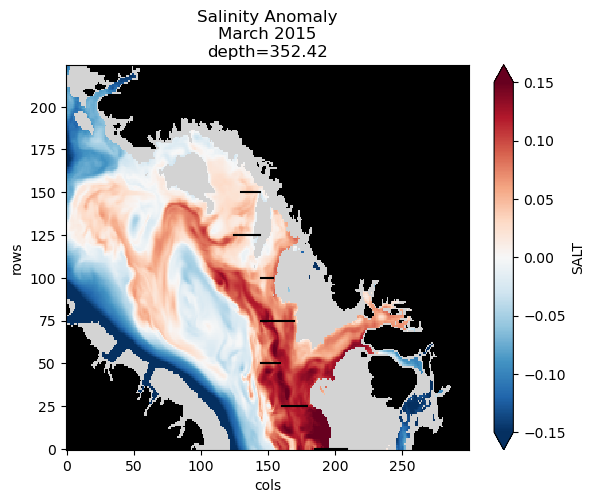

In [18]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

## salt ocean surface
salt_350m_ocean = salt_350m.SALT.where(salt_350m.SALT>0,drop=True)

(salt_350m_ocean-salt_350m_ocean.mean()).plot(ax=ax1,vmin=-0.15,vmax=0.15,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

# add lines
ax1.plot(np.arange(185,210), [0]*len(np.arange(185,210)),color='k')
ax1.plot(np.arange(160,180), [25]*len(np.arange(160,180)),color='k')
ax1.plot(np.arange(145,160), [50]*len(np.arange(145,160)),color='k')
ax1.plot(np.arange(145,170), [75]*len(np.arange(145,170)),color='k')
ax1.plot(np.arange(145,155), [100]*len(np.arange(145,155)),color='k')
ax1.plot(np.arange(125,145), [125]*len(np.arange(125,145)),color='k')
ax1.plot(np.arange(130,145), [150]*len(np.arange(130,145)),color='k')

ax1.set_title("Salinity Anomaly\nMarch 2015\ndepth=" + str(salt_350m.depth.values));

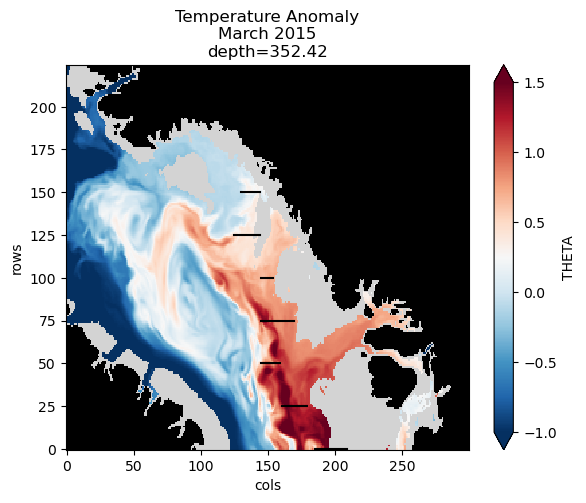

In [19]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

theta_350m_ocean = theta_350m.THETA.where(salt_350m.SALT>0,drop=True)

(theta_350m_ocean-theta_350m_ocean.mean()).plot(ax=ax1,vmin=-1,vmax=1.5,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

# add lines
ax1.plot(np.arange(185,210), [0]*len(np.arange(185,210)),color='k')
ax1.plot(np.arange(160,180), [25]*len(np.arange(160,180)),color='k')
ax1.plot(np.arange(145,160), [50]*len(np.arange(145,160)),color='k')
ax1.plot(np.arange(145,170), [75]*len(np.arange(145,170)),color='k')
ax1.plot(np.arange(145,155), [100]*len(np.arange(145,155)),color='k')
ax1.plot(np.arange(125,145), [125]*len(np.arange(125,145)),color='k')
ax1.plot(np.arange(130,145), [150]*len(np.arange(130,145)),color='k')

ax1.set_title("Temperature Anomaly\nMarch 2015\ndepth=" + str(theta_350m.depth.values));

#### Plot bathymetry over model domain

Load bathymetry data

In [6]:
gebco_bathy = xr.open_dataset("F:/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc")

In [7]:
gebco_bathy_select = gebco_bathy.sel(lon=slice(-75,-56),lat=slice(69,76)).elevation.load()

In [11]:
# remove land
theta_350m_ocean = theta_201503_350m.THETA.where(salt_201503_350m.SALT>0,drop=True)
salt_350m_ocean = salt_201503_350m.SALT.where(salt_201503_350m.SALT>0,drop=True)

In [12]:
# select March 1st
theta_350m_20150301 = theta_350m_ocean.isel(time=0)
salt_350m_20150301 = salt_350m_ocean.isel(time=0)

In [25]:
salt_350m_ocean_anomaly = (salt_350m_ocean-salt_350m_ocean.mean()).load()

Plot lines for each row transect that we are analyzing

In [13]:
## subset lines that we extracted for AW boxes
salt_row000_AW_line = salt_350m_ocean.isel(time=0,rows=0,  cols=slice(185,210))
salt_row025_AW_line = salt_350m_ocean.isel(time=0,rows=25, cols=slice(160,180))
salt_row050_AW_line = salt_350m_ocean.isel(time=0,rows=50, cols=slice(145,160))
salt_row075_AW_line = salt_350m_ocean.isel(time=0,rows=75, cols=slice(145,170))
salt_row100_AW_line = salt_350m_ocean.isel(time=0,rows=100,cols=slice(145,155))
salt_row125_AW_line = salt_350m_ocean.isel(time=0,rows=125,cols=slice(125,145))
salt_row150_AW_line = salt_350m_ocean.isel(time=0,rows=150,cols=slice(130,145))

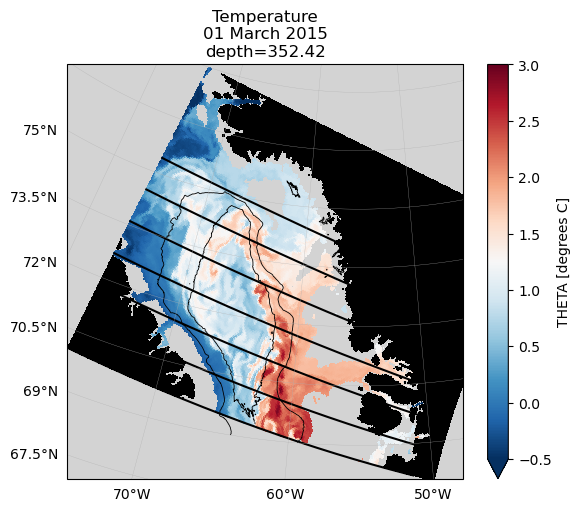

In [31]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

# theta_350m_ocean = theta_201503_350m.THETA.where(salt_201503_350m.SALT>0,drop=True)
# theta_350m_ocean.isel(time=0).plot(y='latitude',x='longitude',ax=ax1,transform=ccrs.PlateCarree())

theta_350m_20150301.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_350m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_350m.depth.values));

## plot rows over model area
plt.plot(salt_350m_20150301.isel(rows=0).longitude,  salt_350m_20150301.isel(rows=0).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_350m_20150301.isel(rows=25).longitude, salt_350m_20150301.isel(rows=25).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_350m_20150301.isel(rows=50).longitude, salt_350m_20150301.isel(rows=50).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_350m_20150301.isel(rows=75).longitude, salt_350m_20150301.isel(rows=75).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_350m_20150301.isel(rows=100).longitude, salt_350m_20150301.isel(rows=100).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_350m_20150301.isel(rows=125).longitude, salt_350m_20150301.isel(rows=125).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_350m_20150301.isel(rows=150).longitude, salt_350m_20150301.isel(rows=150).latitude, c='k',transform=ccrs.PlateCarree());

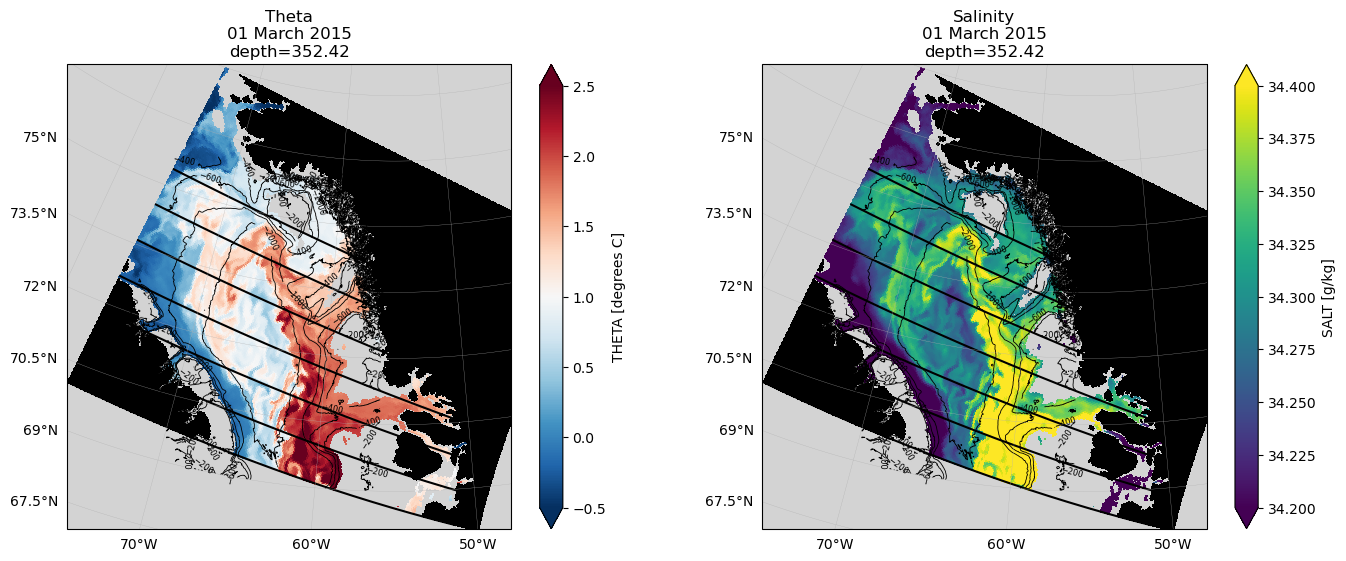

In [18]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_20150301.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=2.5,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_20150301.plot(y='latitude',x='longitude',ax=ax2,vmin=34.2,vmax=34.4,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## plot rows over model area
for ax in (ax1,ax2):
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    CS = gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400,-200],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    ax.clabel(CS, CS.levels, inline=True, fontsize=6);
    
    ax.plot(salt_350m_20150301.isel(rows=0).longitude,  salt_350m_20150301.isel(rows=0).latitude, c='k',transform=ccrs.PlateCarree())
    ax.plot(salt_350m_20150301.isel(rows=25).longitude, salt_350m_20150301.isel(rows=25).latitude, c='k',transform=ccrs.PlateCarree())
    ax.plot(salt_350m_20150301.isel(rows=50).longitude, salt_350m_20150301.isel(rows=50).latitude, c='k',transform=ccrs.PlateCarree())
    ax.plot(salt_350m_20150301.isel(rows=75).longitude, salt_350m_20150301.isel(rows=75).latitude, c='k',transform=ccrs.PlateCarree())
    ax.plot(salt_350m_20150301.isel(rows=100).longitude, salt_350m_20150301.isel(rows=100).latitude, c='k',transform=ccrs.PlateCarree())
    ax.plot(salt_350m_20150301.isel(rows=125).longitude, salt_350m_20150301.isel(rows=125).latitude, c='k',transform=ccrs.PlateCarree())
    ax.plot(salt_350m_20150301.isel(rows=150).longitude, salt_350m_20150301.isel(rows=150).latitude, c='k',transform=ccrs.PlateCarree());

ax1.set_title("Theta\n01 March 2015\ndepth=" + str(theta_350m.depth.values));
ax2.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_350m.depth.values));

Plot lines for each box section for AW

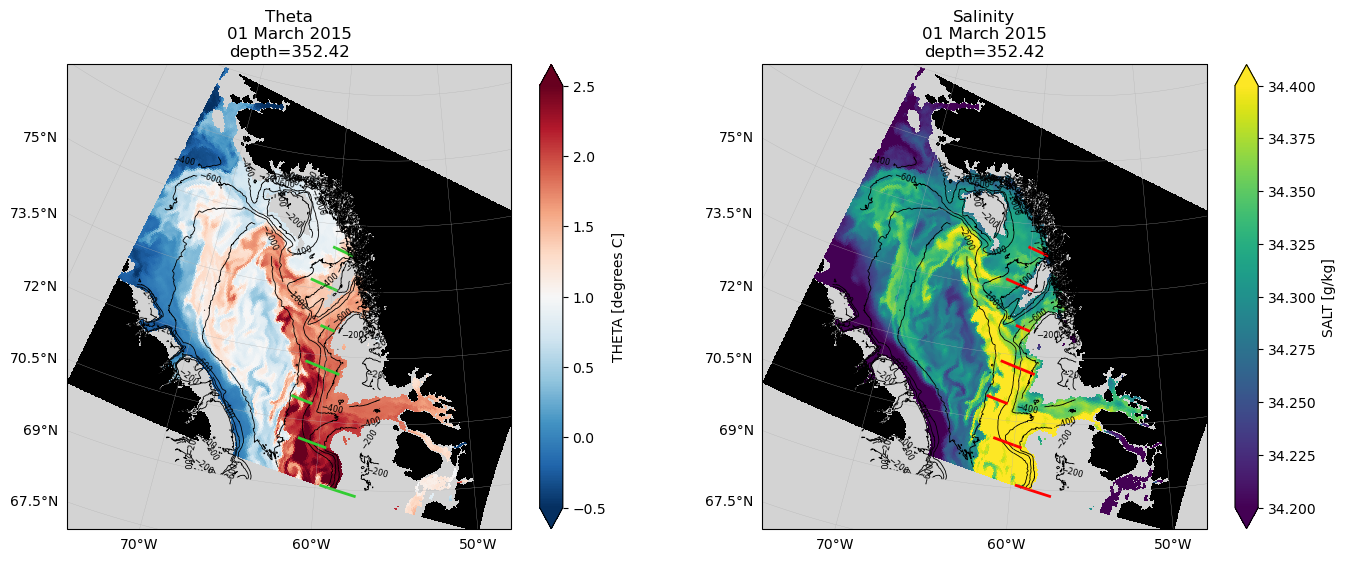

In [15]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_20150301.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=2.5,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_20150301.plot(y='latitude',x='longitude',ax=ax2,vmin=34.2,vmax=34.4,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())
ax2.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_350m.depth.values));

## plot rows over model area
for ax in (ax1,ax2):
    
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    CS = gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400,-200],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    ax.clabel(CS, CS.levels, inline=True, fontsize=6);
    
## add lines for what boxes we are selecting along each row
ax1.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='limegreen',linewidth=2,transform=ccrs.PlateCarree())

## add lines for what boxes we are selecting along each row
ax2.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())

ax1.set_title("Theta\n01 March 2015\ndepth=" + str(theta_350m.depth.values));
ax2.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_350m.depth.values));

### 350 m

Plot annual climatology

In [22]:
theta_350m_annual = theta_time_ds.sel(depth=350,method='nearest').mean(['time']).set_coords(['latitude','longitude'])
salt_350m_annual = salt_time_ds.sel(depth=350,method='nearest').mean(['time']).set_coords(['latitude','longitude'])

In [23]:
# remove land cells
theta_350m_annual = theta_350m_annual.where(salt_350m_annual.SALT>0,drop=True)
salt_350m_annual = salt_350m_annual.where(salt_350m_annual.SALT>0,drop=True)

In [24]:
# load to memory
theta_350m_annual = theta_350m_annual.THETA.load()
salt_350m_annual = salt_350m_annual.SALT.load()
land_mask_latlon = land_mask_latlon.SALT.load()

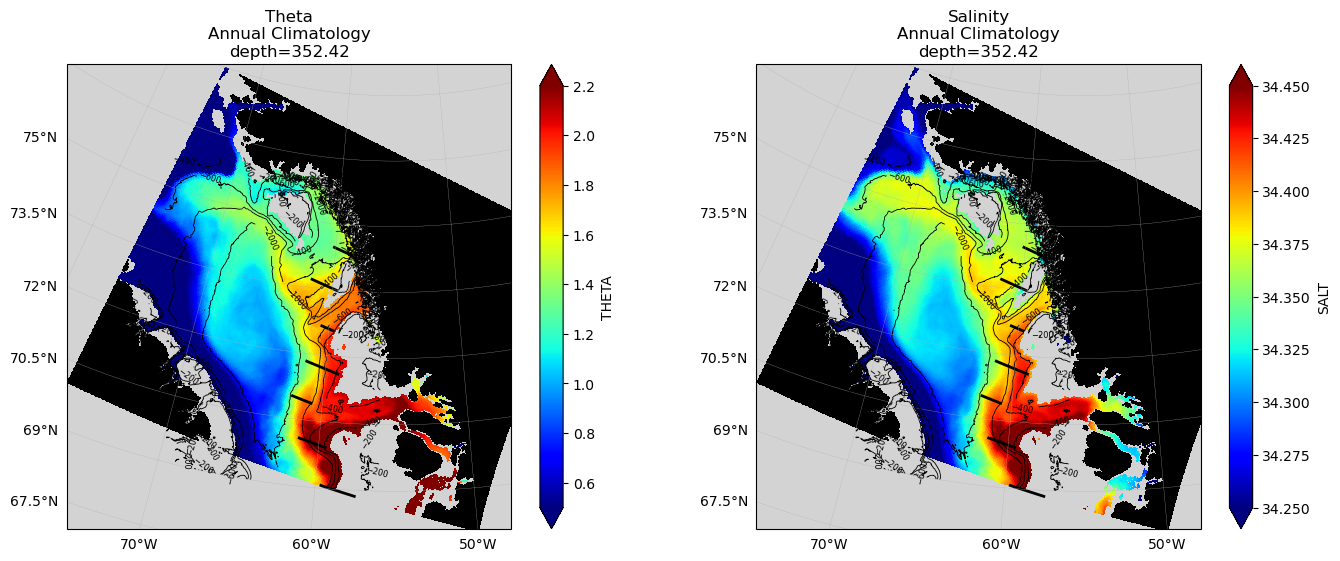

In [27]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_annual.plot(y='latitude',x='longitude',ax=ax1,cmap='jet',vmin=0.5,vmax=2.2,transform=ccrs.PlateCarree())
land_mask_latlon.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_annual.plot(y='latitude',x='longitude',ax=ax2,cmap='jet',vmin=34.25,vmax=34.45,transform=ccrs.PlateCarree())
land_mask_latlon.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## plot rows over model area
for ax in (ax1,ax2):
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    CS = gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400,-200],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    ax.clabel(CS, CS.levels, inline=True, fontsize=6);
    
    ## add lines for what boxes we are selecting along each row
    ax.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())

ax1.set_title("Theta\nAnnual Climatology\ndepth=" + str(theta_350m.depth.values));
ax2.set_title("Salinity\nAnnual Climatology\ndepth=" + str(salt_350m.depth.values));

Without labels for isobaths

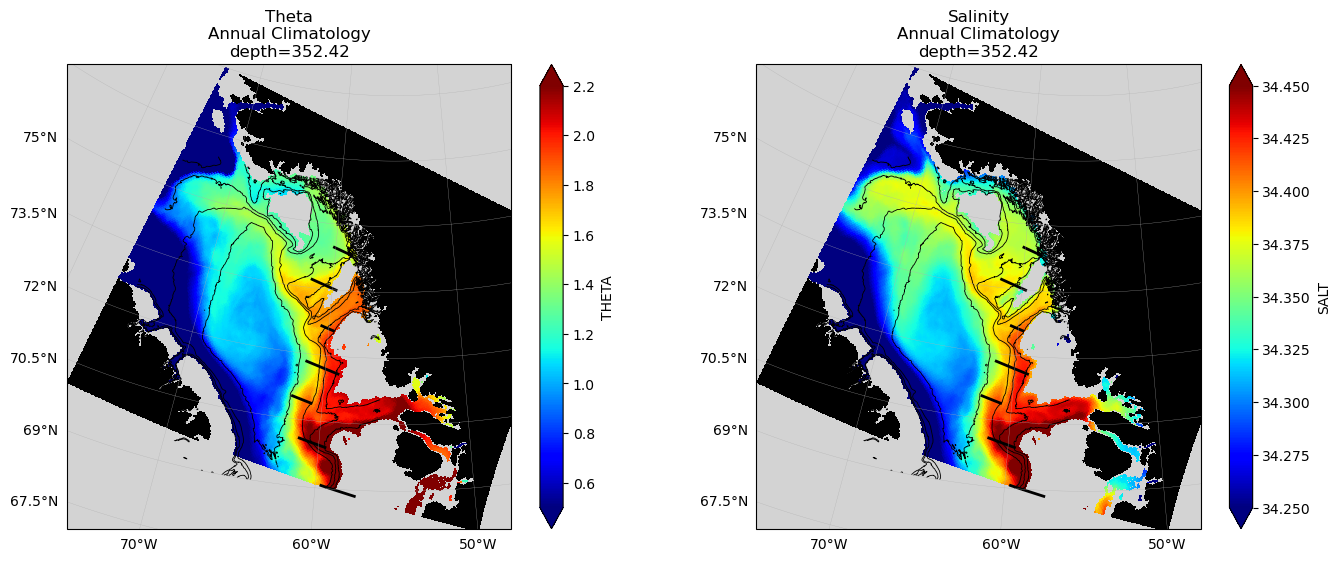

In [28]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_annual.plot(y='latitude',x='longitude',ax=ax1,cmap='jet',vmin=0.5,vmax=2.2,transform=ccrs.PlateCarree())
land_mask_latlon.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_annual.plot(y='latitude',x='longitude',ax=ax2,cmap='jet',vmin=34.25,vmax=34.45,transform=ccrs.PlateCarree())
land_mask_latlon.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## plot rows over model area
for ax in (ax1,ax2):
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    
    ## add lines for what boxes we are selecting along each row
    ax.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())

ax1.set_title("Theta\nAnnual Climatology\ndepth=" + str(theta_350m.depth.values));
ax2.set_title("Salinity\nAnnual Climatology\ndepth=" + str(salt_350m.depth.values));

Adjust row 100 to be wider (offshore closer to 1000 m isobath)

In [29]:
salt_row100_AW_line = salt_350m_ocean.isel(time=0,rows=100,cols=slice(125,155))

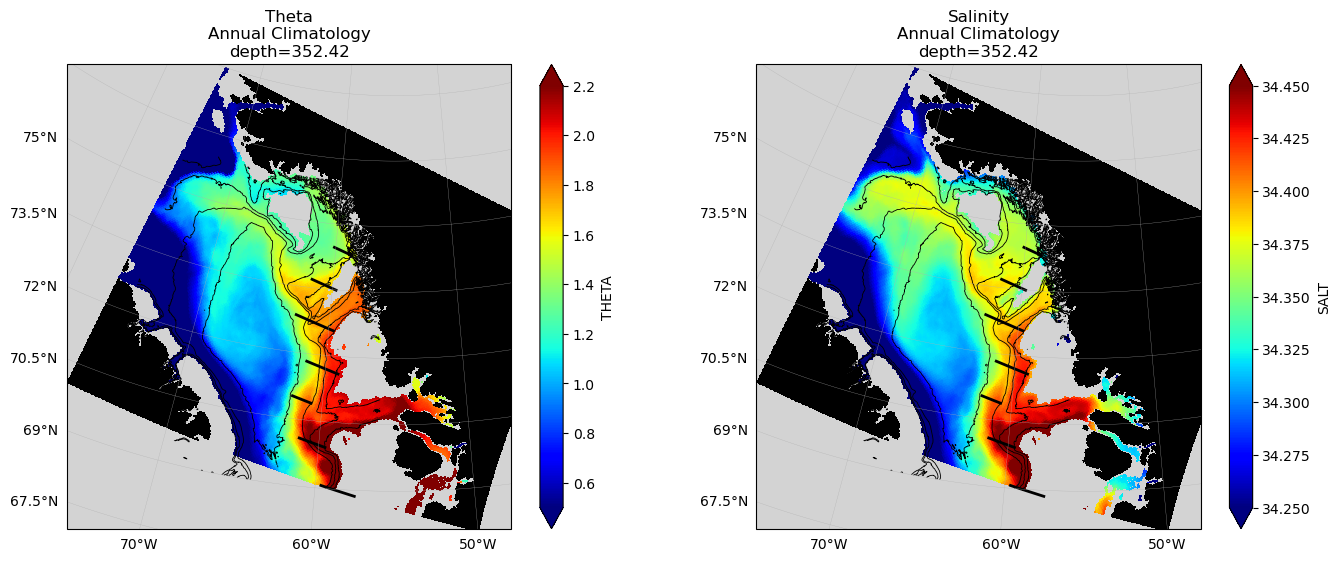

In [30]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_annual.plot(y='latitude',x='longitude',ax=ax1,cmap='jet',vmin=0.5,vmax=2.2,transform=ccrs.PlateCarree())
land_mask_latlon.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_annual.plot(y='latitude',x='longitude',ax=ax2,cmap='jet',vmin=34.25,vmax=34.45,transform=ccrs.PlateCarree())
land_mask_latlon.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## plot rows over model area
for ax in (ax1,ax2):
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    
    ## add lines for what boxes we are selecting along each row
    ax.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
    ax.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())

ax1.set_title("Theta\nAnnual Climatology\ndepth=" + str(theta_350m.depth.values));
ax2.set_title("Salinity\nAnnual Climatology\ndepth=" + str(salt_350m.depth.values));